In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Прочитайте данные (переменную назовите 'df')
df = pd.read_csv('data.csv')

# Вывести несколько первых строк таблицы данных
print(df.head())

         Дата  Склад Контрагент Номенклатура  Количество
0  2018-01-04      1  address_0    product_0           4
1  2018-01-04      1  address_0    product_1           4
2  2018-01-04      1  address_0    product_2           5
3  2018-01-04      1  address_0    product_3          10
4  2018-01-04      1  address_0    product_4           2


Проверяем формат столбцов

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301355 entries, 0 to 301354
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Дата          301355 non-null  object
 1   Склад         301355 non-null  int64 
 2   Контрагент    301355 non-null  object
 3   Номенклатура  301355 non-null  object
 4   Количество    301355 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.5+ MB
None


Сразу переведем столбец "Дата" в правильный формат

In [7]:
df['Дата'] = pd.to_datetime(df['Дата'], format='%Y-%m-%d')
print(df.dtypes)

Дата            datetime64[ns]
Склад                    int64
Контрагент              object
Номенклатура            object
Количество               int64
dtype: object


Сгруппируйте данные по дате, посчитайте количество продаж

In [8]:
grouped_df = df.groupby('Дата')['Количество'].sum().reset_index()
print(grouped_df.head())

        Дата  Количество
0 2018-01-04        3734
1 2018-01-05        3643
2 2018-01-06        3193
3 2018-01-07        3298
4 2018-01-09        4055


Вывести несколько первых строк сгруппированных данных

In [9]:
print(grouped_df.head())

        Дата  Количество
0 2018-01-04        3734
1 2018-01-05        3643
2 2018-01-06        3193
3 2018-01-07        3298
4 2018-01-09        4055


Нарисуйте график продаж у `grouped_df`

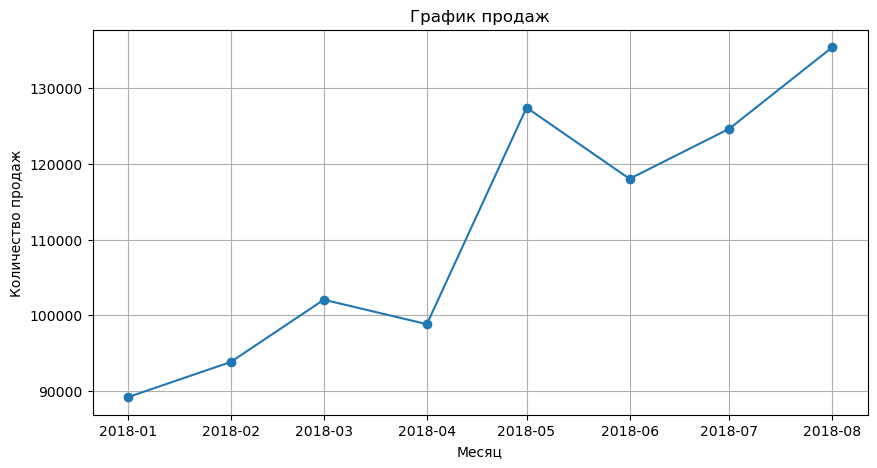

In [12]:
monthly_sales = df.groupby(df['Дата'].dt.to_period('M'))['Количество'].sum().reset_index()
monthly_sales['Дата'] = monthly_sales['Дата'].dt.to_timestamp()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(monthly_sales['Дата'], monthly_sales['Количество'], marker='o')
plt.title("График продаж")
plt.xlabel("Месяц")
plt.ylabel("Количество продаж")
plt.grid(True)
plt.show()

Опишите что вы видите на графике. Ваша задача - максимально описать график

In [ ]:
На графике показано количество продаж по датам. Ось х это месяца, а ось у общее количество продаж по месяцам. 
Пик по продажам приходится на Август месяц, а самый малый результат январь. Скачок по продажам приходится на май месяц.
По графику можем увидеть месяца где спрос был увеличен

Найдите строку, у которой максимальный выброс по количеству продаж (нужно найти выброс у `df`)

In [13]:
max_row = df.loc[df['Количество'].idxmax()]
print(max_row)

Дата            2018-06-28 00:00:00
Склад                             1
Контрагент              address_208
Номенклатура              product_0
Количество                      200
Name: 218822, dtype: object


Найдите топовый товар по продажам по средам за июнь, июль, август у 3 склада

In [15]:
filtered = df[
    (df['Дата'].dt.month.isin([6, 7, 8])) &     
    (df['Дата'].dt.weekday == 2) &              
    (df['Склад'] == 3)]
top_product = (filtered.groupby('Номенклатура')['Количество']
    .sum()
    .reset_index()
    .sort_values(by='Количество', ascending=False)
    .head(1))

print(top_product)

  Номенклатура  Количество
1    product_1        2267


Скачайте данные по погоде с https://rp5.ru/Архив_погоды_в_Астане (скачайте исходные данные, и далее преобразуйте так, чтобы мы имели Дату и Среднюю температуру за день), объедините таблицу температуры с `grouped_df`, и нарисуйте график `y=['Количество продаж', 'T']`, где Т это температура. А также отдельно график температуры.

        Date  Количество продаж     T
0 2018-08-08               4769   8.1
1 2018-08-14               6004  14.1
2 2018-08-15               4876  15.1
3 2018-08-16               5071  16.1
4 2018-08-17               5286  17.1


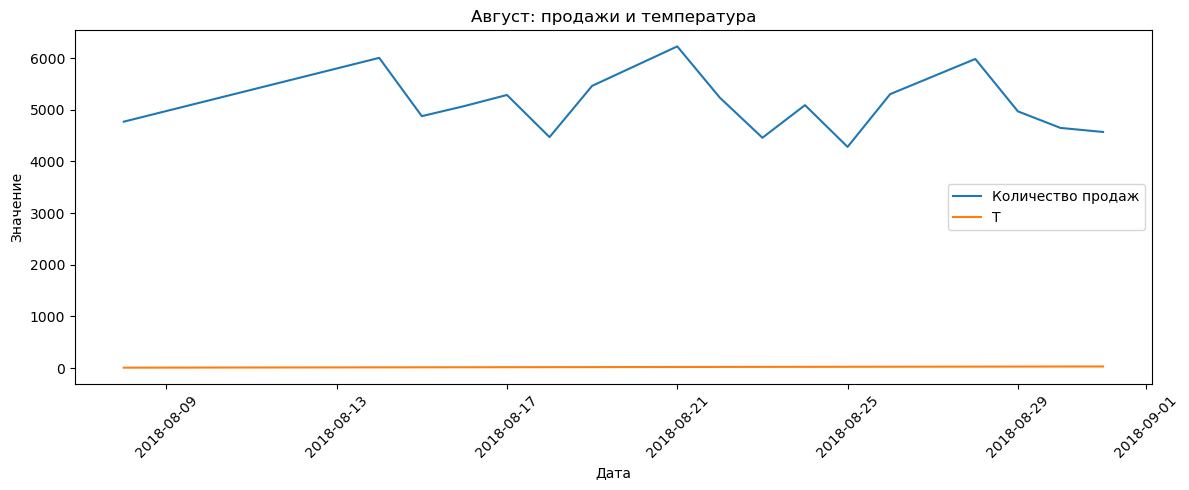

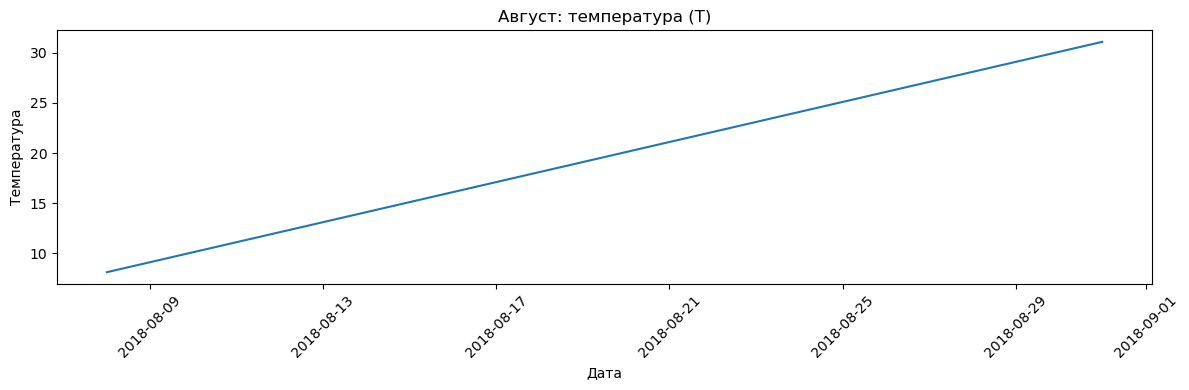

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import re

PATH_TEMP  = r"./Weather_Ast_daily_avg.csv"
PATH_SALES = r"./data.csv"  

def parse_date(s):
    d = pd.to_datetime(s, errors="coerce", dayfirst=True)
    m = d.isna()
    if m.any(): d.loc[m] = pd.to_datetime(s[m], errors="coerce")  # fallback
    return d.dt.normalize()

def to_num(s):
    return pd.to_numeric(
        s.astype(str).str.replace(",", ".", regex=False).str.extract(r"(-?\d+\.?\d*)")[0], errors="coerce")

def pick_date_col(df):
    for c in df.columns:
        if re.search(r"\bdate\b|дата|time|время", str(c).lower()):
            return c
    return df.columns[0]

def pick_sales_col(df, date_col):
    patt = r"прод|sales|count|qty|quantity|units|orders|transactions|кол-во|количество"
    for c in df.columns:
        if c != date_col and re.search(patt, str(c).lower()):
            return c
    nums = [c for c in df.columns if c != date_col and to_num(df[c]).notna().sum() > 0]
    if not nums: raise ValueError("Не найден столбец с количеством продаж.")
    return nums[-1]

t = pd.read_csv(PATH_TEMP, sep=None, engine="python", encoding="utf-8-sig")
t_date_col = pick_date_col(t)
t = t.rename(columns={"Средняя температура за день": "T"}) if "Средняя температура за день" in t.columns else t
if "T" not in t.columns: 
    t = t.rename(columns={ [c for c in t.columns if c != t_date_col][0]: "T" })
t["Date"] = parse_date(t[t_date_col])
t["T"] = to_num(t["T"])
t = t[["Date", "T"]].dropna(subset=["Date"]).copy()

s = pd.read_csv(PATH_SALES, sep=None, engine="python", encoding="utf-8-sig")
s_date_col = pick_date_col(s)
s["Date"] = parse_date(s[s_date_col])
sales_col = pick_sales_col(s, s_date_col)
s["Количество продаж"] = to_num(s[sales_col])
grouped_df = (s.dropna(subset=["Date"])
               .groupby("Date", as_index=False)["Количество продаж"].sum())

years_sales = set(grouped_df["Date"].dt.year.unique())
years_temp  = set(t["Date"].dt.year.unique())
common_years = sorted(years_sales & years_temp)
YEAR = common_years[0] if common_years else None

mask_sales_aug = grouped_df["Date"].dt.month.eq(8) & (True if YEAR is None else grouped_df["Date"].dt.year.eq(YEAR))
mask_temp_aug  = t["Date"].dt.month.eq(8)         & (True if YEAR is None else t["Date"].dt.year.eq(YEAR))

sales_aug = grouped_df.loc[mask_sales_aug].copy()
temp_aug  = t.loc[mask_temp_aug].copy()

merged_aug = sales_aug.merge(temp_aug, on="Date", how="inner").sort_values("Date")
print(merged_aug.head())
merged_aug.to_csv("./merged_august.csv", index=False, encoding="utf-8-sig")

x = pd.to_datetime(merged_aug["Date"])

plt.figure(figsize=(12,5))
plt.plot(x, merged_aug["Количество продаж"], label="Количество продаж")
plt.plot(x, merged_aug["T"], label="T")
plt.title("Август: продажи и температура")
plt.xlabel("Дата"); plt.ylabel("Значение")
plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,4))
plt.plot(x, merged_aug["T"])
plt.title("Август: температура (T)")
plt.xlabel("Дата"); plt.ylabel("Температура")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()
